# Image segmentation

In this notebook we will learn how to create an image segmentation model based on the U-Net neural network.

![unet](https://github.com/mlcollege/rbi/blob/master/flagship/Deep-Learning-and-Image-Processing/images/unet.png?raw=1)

## Download data from the Git repository

In [ ]:
!gdown https://drive.google.com/uc?id=1n0TeSBm-oNUn56J3QgG2u7YKsxnEZ2ub
!unzip -o membrane.zip

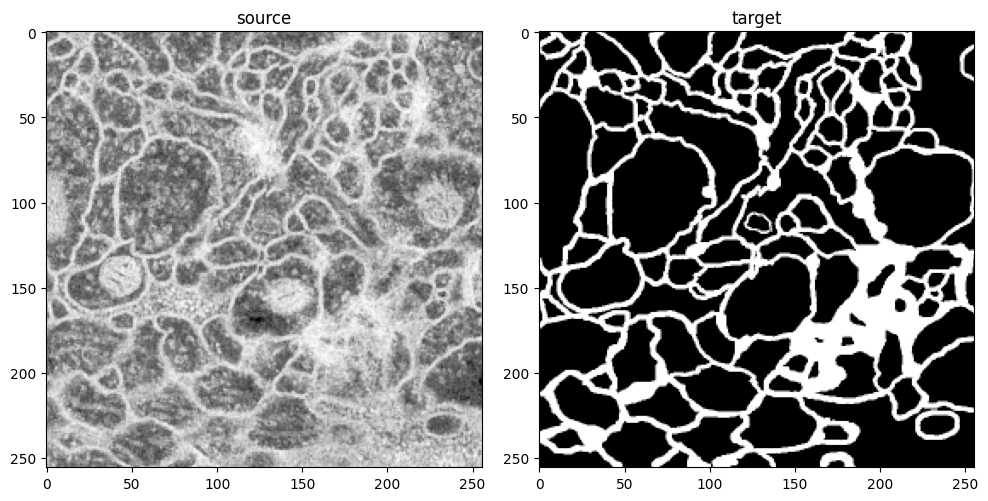

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

testPath = 'membrane/train/'

for f in os.listdir(testPath + 'image/'):
    source = io.imread(testPath +'image/'+ f, as_gray=True)
    source = cv2.resize(source, (256, 256))
    target = io.imread(testPath +'label/'+ f, as_gray=True)
    target = cv2.resize(target, (256, 256))

    f, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(source, cmap='Greys')
    ax[1].imshow(target, cmap='Greys')

    ax[0].set_title('source')
    ax[1].set_title('target')

    plt.tight_layout()
    plt.show()

    break

## Data preparation rutines

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def dataGenerator(dataPath, sourceFolder, targetFolder, shape, augDict, batchSize=1, seed=1):
    source_datagen = ImageDataGenerator(**augDict)
    target_datagen = ImageDataGenerator(**augDict)
    sourceGenerator = source_datagen.flow_from_directory(
            dataPath,
            classes = [sourceFolder],
            class_mode = None,
            color_mode = 'grayscale',
            target_size = shape,
            batch_size = batchSize,
            seed=seed
        )

    targetGenerator = target_datagen.flow_from_directory(
            dataPath,
            classes = [targetFolder],
            class_mode = None,
            color_mode = 'grayscale',
            target_size = shape,
            batch_size = batchSize,
            seed = seed,
        )

    generator = zip(sourceGenerator, targetGenerator)
    for (img, mask) in generator:
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img, mask)


## U-Net model definition

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

inputs = Input((256,256,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6],axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint = ModelCheckpoint('unet_membrane.keras', monitor='loss',verbose=1, save_best_only=True)

#!rm unet_membrane.keras
#!gdown https://drive.google.com/uc?id=1AejR9Vy80zKiwcIvRushKRiW1W-krkcn
#model.load_weights('unet_membrane.keras')

## Training the model

In [ ]:
dataAugmentation = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

generator = dataGenerator('membrane/train','image','label', (256, 256), dataAugmentation)

model.fit(generator, steps_per_epoch=200, epochs=1, callbacks=[checkpoint])
#model.fit(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint])


## Prediction on test data

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

testPath = 'membrane/test/'

for f in os.listdir(testPath):
    source = io.imread(testPath + f, as_gray=True)
    source = cv2.resize(source, (256, 256))
    batch = source[np.newaxis, :, :, np.newaxis]
    batch = batch / 255
    pred = model.predict(batch)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 255

    f, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(source, cmap='Greys')
    ax[1].imshow(pred[0,:,:,0], cmap='Greys')

    ax[0].set_title('source')
    ax[1].set_title('prediction')

    plt.tight_layout()
    plt.show()

    break

